In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import torchvision
from torchvision import transforms
import torch

from utils.classes import Client
from models.cifar_models import simple_CNN
from utils.initialization_utils import sample_cifargroups

# set random seed
np.random.seed(0)
torch.manual_seed(0)


# Function to calculate KL divergence
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# Function to convert images to normalized histograms
def images_to_prob_dist(loader):
    
    combined_hist = np.zeros(256)
    for data, label in loader:
        # convert to grayscale
        data = data.mean(1)
        # convert to numpy
        data = data.numpy()
        # convert to histogram
        hist, _ = np.histogram(data.flatten(), bins=256, range=(0, 256), density=True)
        combined_hist += hist

    prob_dist = combined_hist / np.sum(combined_hist)
    return prob_dist



In [47]:
 # load dataset and transform
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('.', train=True, download=True, transform=trans_cifar)

class Args:
    def __init__(self):
        self.nbr_clients = 100
        self.n_data_train = 400
        self.n_data_val = 100
        self.lr = 0.01
        self.batch_size = 10
        self.stopping_rounds = 10
        self.gpu = 0

Files already downloaded and verified


about to start


/tmp/ipykernel_413563/820476855.py:19: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


divergences: [9.55482048157195e-06, 0.0008183025489652994, 0.0021021624553777324, 0.0013104784805065012, 0.01311214988892379, 0.0012527729531642152, 0.00040173259713363347, 0.005019687401730359, 0.0018918201833562978, 0.002513940358847777, 0.003765615570442006, 0.010895740330256828, 0.0007036274602695378, 7.55766873989836e-05, 0.003249296831965738, 0.0005587210911705636, 0.00013826250061209355, 0.0014297285189084881, 0.0009460038369022905, 0.004294232629137825, 0.0013078304652906153, 0.0003977863598113116, 0.0022889482082075873, 0.002381025896529416, 0.0012367788828220368, 0.0014350592398638127, 0.0030827490326742566, 0.0014055020262198192, 0.001974494505718947, 0.004258334672401673, 0.0009152457066659214, 0.0015573362296187523, 0.0007980003971413806, 0.0019187343366218216, 0.000760913329117774, 0.00039929241966757097, 0.0019221772738643172, 0.004392075208297767, 0.0034818963692039556, 0.0004719873031877571, 0.00011308107583017711, 0.00010769708003891183, 0.002575908594512893, 0.001448

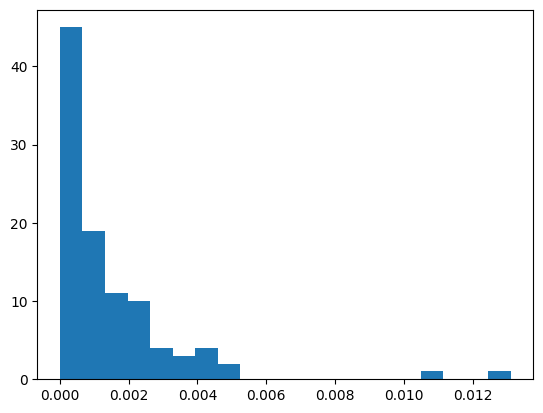

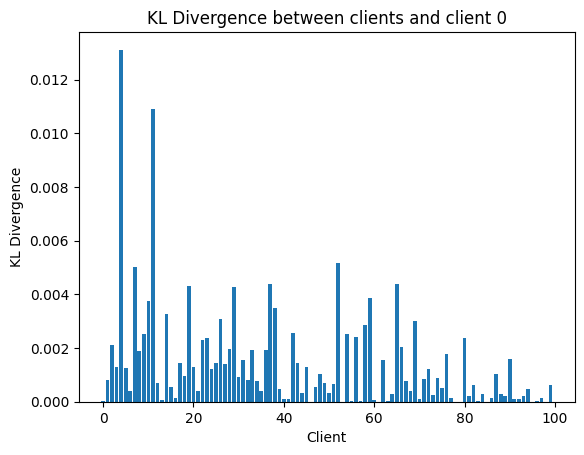

In [48]:
args = Args()

# Set the device to use
if args.gpu == -1:
    device = torch.device('cpu')
else:
    device = torch.device('cuda:{}'.format(args.gpu))

# assign data to clients (for now label shift, animals and vehicles)
# TODO: covariate shift
dict_users, dict_users_val = sample_cifargroups(train_dataset, args.nbr_clients, args.n_data_train, args.n_data_val)
# dicts contain indices of data for each client

# load model (same initialization for all clients)
client_model_init = simple_CNN(nbr_classes=10)

# create clients
clients = []
for i in range(args.nbr_clients):
    client = Client(train_set=train_dataset, 
                    idxs_train=dict_users[i], 
                    idxs_val=dict_users_val[i], 
                    criterion=torch.nn.CrossEntropyLoss(), 
                    lr=args.lr, 
                    device=device, 
                    batch_size=args.batch_size, 
                    num_users=args.nbr_clients, 
                    model=client_model_init,
                    idx=i,
                    stopping_rounds=args.stopping_rounds)
    clients.append(client)

prob_dist1 = images_to_prob_dist(clients[0].ldr_train)

print('about to start')
divergences = []
for client in clients:
    prob_dist2 = images_to_prob_dist(client.ldr_train)
    kl_div = kl_divergence(prob_dist1, prob_dist2)
    # if kl_div is inf, change it to 1
    if np.isinf(kl_div):
        kl_div = 1
        print('kl_div is inf')
    divergences.append(kl_div)

print('divergences:', divergences)

plt.hist(divergences, bins=20)
plt.show()

# plot divergences in a bar plot
fig, ax = plt.subplots()
ax.bar(range(len(divergences)), divergences)
ax.set_xlabel('Client')
ax.set_ylabel('KL Divergence')
ax.set_title('KL Divergence between clients and client 0')
plt.show()


In [49]:
# print average KL divergence for indices 0-39
print('average KL divergence')
print(np.mean(divergences[:40]))

# print average KL divergence for indices 40-99
print('average KL divergence')
print(np.mean(divergences[40:]))

average KL divergence
0.002271889375211951
average KL divergence
0.000879984690232419
